# Plot difference-based anomaly detection results



In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml

In [ ]:
# Read the CSV results
video_name = "FH" + "102_02"
# video_name = "PICT7_16DD_2022-07-30_06-00_006"
results_folder = "./results_diffs/humbs/"
df_change = pd.read_csv(
    f"./{results_folder}/{video_name}_processed_diff.csv"
)

df_change.index = df_change["center_idx"]
df_change = df_change.drop(columns=["center_idx"])

# read the yaml config as well
with open(f"./{results_folder}/{video_name}_diff_config.yaml", "r") as file:
    config = yaml.safe_load(file)

extension = "avi" #config["video_processing"]["extension"]
filename = f"./data/{video_name}.{extension}"

# Print the config dictionary in a nicely formatted way
for key, value in config.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}") 

frame_difference_analysis:
  running_mean_N: 20
  use_running_mean: True
output:
  config_file: FH102_02_diff_config.yaml
  csv_file: FH102_02_processed_diff.csv
  output_folder: results_diffs/humbs
preprocessing:
  crop_box: [0, 0, 1280, 700]
video_processing:
  extension: .avi
  frame_skip: [1]
  video_name: FH102_02
  video_path: data/FH102_02.avi
  visualize: False


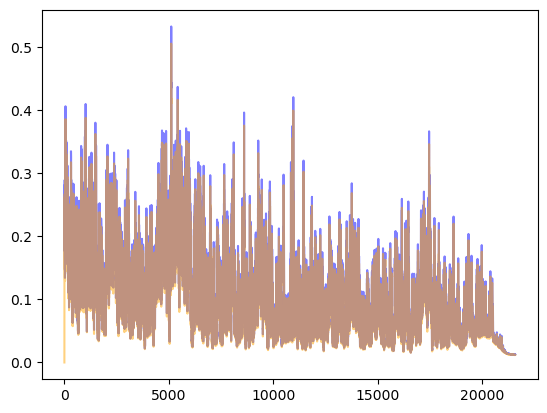

In [25]:
plt.plot(df_change.index, df_change["std_diff_running_mean_20"], label="Diff", color="blue", alpha=0.5)
plt.plot(df_chang_new.index, df_chang_new["std_diff_running_mean_20"], label="Diff New", color="orange", alpha=0.5)
         

In [ ]:
# Plotting the results for all columns in the dataframe starting with "std_diff_" in the same axes
ax = plt.figure(figsize=(12, 6)).add_subplot(111)
# for column in df_change.columns:
    # plt.plot(df_change.index, df_change[column], label=column, alpha=0.7)

colname_running_mean = f'std_diff_running_mean_{config["frame_difference_analysis"]["running_mean_N"]}'
colname_frame_diff = f'std_diff_rgb_{config["video_processing"]["frame_skip"][0]}'

plt.plot(df_change.index, df_change[colname_running_mean].diff().abs(), label=colname_running_mean, color='blue', alpha=0.7)
plt.plot(df_change.index, df_change[colname_frame_diff].diff().abs(), label=colname_frame_diff, color='red', alpha=0.7)

for x in range(1, df_change.index.max(), 500):
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5, zorder=0)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', zorder=0)


plt.title("Standard Deviation of RGB Differences")
plt.xlabel("Frame Index")
plt.ylabel("Standard Deviation")
plt.legend()
plt.grid()
plt.tight_layout()


        

## Extract ground truth for video and mark on plots

In [ ]:
# Load ground truth CSV and extract FH401_01 rows
gt = pd.read_csv('./data/Weinstein2018MEE_ground_truth.csv')
gt_video = gt[gt['Video'] == video_name]
gt_video = gt_video.set_index('Frame', drop=False)

# deduplicate the index of ground truth
gt_video = gt_video[~gt_video.index.duplicated(keep='first')]
print(f"number of labels in ground truth: \n {gt_video.groupby('Truth').size()}")


In [ ]:
# Plot aggregated_diff with ground truth arrows for FH303_01
# for column in df_change.columns:
#     if column.startswith('std_diff_'):
#         df_change[column + "_rate_change"] = df_change[column].diff().abs()  # Ensure all differences are positive

df_change["aggregated_diff"] = df_change.filter(like=colname_running_mean).mean(axis=1)
# df_change['aggregated_diff'] = df_change.filter(like='_rate_change').mean(axis=1)

# df_change['aggregated_diff'] = df_change["std_diff_running_mean_20"].diff().abs()

# 0 - 1 norm
df_change['aggregated_diff'] = (df_change['aggregated_diff'] - df_change['aggregated_diff'].min()) / (df_change['aggregated_diff'].max() - df_change['aggregated_diff'].min())

fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(df_change.index, df_change['aggregated_diff'], label='aggregated_diff', color='orange')

for x in range(1, df_change.index.max(), 500):
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5, zorder=0)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color='gray', zorder=0)

# Only plot if ground truth is available
if not gt_video.empty:
    # Arrow up for Positive, arrow down for Negative
    positives = gt_video[gt_video['Truth'].str.lower() == 'positive']
    negatives = gt_video[gt_video['Truth'].str.lower() == 'negative']
    ax.scatter(positives.index, [1.05] * len(positives), marker='v', color='red', label='Positive (GT)', zorder=5)
    ax.scatter(negatives.index, [-0.05] * len(negatives), marker='^', color='blue', label='Negative (GT)', zorder=5)
    
    # Annotate positive markers with frame IDs, spreading out text if labels are close
    # last_frame_id = None
    # c = 0
    # for frame_id in positives.index:
    #     if last_frame_id is not None and abs(frame_id - last_frame_id) < 100:  # Adjust threshold as needed
    #         offset = 1.1 + 0.25 * c  # Add fixed offset of 1 if condition is true
    #         ax.text(frame_id, offset, str(frame_id), color='red', fontsize=8, ha='center')  # Spread out
    #         c += 1
    #     else:
    #         c = 0
    #         ax.text(frame_id, 1.3, str(frame_id), color='red', fontsize=8, ha='center')
    #     last_frame_id = frame_id

ax.set_ylabel('aggregated_diff')
ax.set_xlabel('center_idx')
ax.legend()

plt.title('Aggregated Diff with Ground Truth Arrows')
plt.tight_layout()
plt.show()

In [ ]:
top_k = 100  # Specify the number of top frames to retrieve
# df_change["aggregated_diff"] = df_change.filter(like='std_diff_').mean(axis=1)

if top_k > 1:
    top_k_frames = df_change.nlargest(top_k, 'aggregated_diff')
else:
    top_k_frames = df_change[df_change['aggregated_diff'] > top_k]
    
top_k_frames = top_k_frames.sort_values(by='aggregated_diff', ascending=False)

chunk_size = 5
top_k_frames = top_k_frames.iloc[:len(top_k_frames) - len(top_k_frames) % chunk_size]

print(top_k_frames[['aggregated_diff']])


In [ ]:
import numpy as np
import random
from torchcodec.decoders import VideoDecoder

video_reader = VideoDecoder(filename)


# Set the number of random frames to sample
num_frames = 100

# define the crop box (left, top, right, bottom)
crop_box = config["preprocessing"]["crop_box"]

if 0:
    # Generate random frame indices
    random_indices = random.sample(range(len(video_reader)), num_frames)

    # Initialize an array to accumulate pixel values
    average_frame = None

    # Iterate through the random frame indices and accumulate pixel values
    for idx in random_indices:
        frame = video_reader[idx].permute(1, 2, 0).numpy()  # Convert frame to numpy array (HWC format)
        if average_frame is None:
            average_frame = np.zeros_like(frame, dtype=np.float64)
        average_frame += frame

    # Compute the average frame
    average_frame /= num_frames

    # Convert the average frame back to uint8 for visualization
    average_frame = average_frame.astype(np.uint8)

    # Display the average frame
    plt.imshow(average_frame)
    plt.title("Average Frame")
    plt.axis("off")
    plt.show()


In [ ]:
chunk_size = 5  # Number of frames per group
chunks = [top_k_frames.index[i:i + chunk_size] for i in range(0, len(top_k_frames), chunk_size)]

for chunk_idx, chunk in enumerate(chunks):
    fig, axes = plt.subplots(1, len(chunk), figsize=(15, 7))
    for i, frame_idx in enumerate(chunk):

        frame = video_reader[frame_idx]
        # frame_before = average_frame # 
        # frame_before = video_reader[frame_idx - 1]

        # Convert the frame from torch tensor to numpy array for plotting
        frame_rgb = frame.permute(1, 2, 0) #.numpy().astype(np.float64)  # Assuming frame is in CHW format
        
        # Plot the frame
        axes[i].imshow(frame_rgb)
        if crop_box:
            # Show the borders of crop, if crop_box is defined
            x, y, w, h = crop_box
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            axes[i].add_patch(rect)
            
        axes[i].set_title(f"Frame {frame_idx}, score: {top_k_frames.loc[frame_idx, 'aggregated_diff']:.4f}")
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()


In [ ]:
from video_frame_diff import preprocess_frame, compute_frame_difference, visualize_rgb_difference

frame_skip = config["video_processing"]["frame_skip"][0]  # Number of frames to skip for comparison

for frame_index in top_k_frames.index[:20]:

    # Buffer for preprocessed frames and histograms
    frame_buffer = []
    rgb_buffer = []

    for i in [frame_index-frame_skip, frame_index, frame_index + frame_skip]:
        frame = video_reader[i].permute(1, 2, 0).cpu().numpy()
        pframe = preprocess_frame(frame, reference=frame, crop_box=crop_box)
        frame_buffer.append(pframe)
        rgb_buffer.append(preprocess_frame(frame, reference=None, crop_box=crop_box))

    diff21, diff23 = compute_frame_difference(frame_buffer[0], frame_buffer[1], frame_buffer[2])
    diff_rgb = np.abs(diff21 + diff23)

    normalize_frame = lambda x: (x - np.min(x)) / (
        np.max(x) - np.min(x)
    )
    diff_rgb_vis = normalize_frame(diff_rgb)
    visualize_rgb_difference(
        rgb_buffer[0]*255, 
        rgb_buffer[1]*255, 
        rgb_buffer[2]*255,
        diff_rgb=diff_rgb_vis*255,
        title1=f"Frame {frame_index-frame_skip}",
        title2=f"Frame {frame_index}",
        title3=f"Frame {frame_index+frame_skip}",
        titled=f"aggregated_diff: {top_k_frames.loc[frame_index, 'aggregated_diff']:.4f}",
    )


In [ ]:
# Create a DataFrame to store the results
results = []
buff = 1

sorted_scores = df_change.sort_values(by='aggregated_diff', ascending=False)

# Iterate through all top_10_frames
for frame in sorted_scores.index:
    is_within_range = any((positives['Frame'] >= frame - buff) & (positives['Frame'] <= frame + buff))
    results.append({'Frame': frame, f'within_{buff}_positive': is_within_range})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Create a DataFrame to store precision and recall values
precision_recall_data = []

for k in list(range(10,201,10)) + list(range(200, 1001, 100)) + list(range(1000, 2001, 500)):
    precision_at_k = results_df[f'within_{buff}_positive'].iloc[:k].sum() / k
    true_positives = results_df["Frame"].iloc[:k].isin(positives["Frame"])
    recall_at_k = true_positives.sum() / len(positives)
    
    precision_recall_data.append({'k': k, 'Precision': precision_at_k, 'Recall': recall_at_k})

# Convert the data to a DataFrame
precision_recall_df = pd.DataFrame(precision_recall_data)

# Plot precision and recall curves with log x-axis
plt.figure(figsize=(10, 6))
plt.plot(precision_recall_df['k'], precision_recall_df['Precision'], label='Precision', marker='o')
plt.plot(precision_recall_df['k'], precision_recall_df['Recall'], label='Recall', marker='o')
plt.axvline(x=len(positives), color='red', linestyle='--', label='Actual Positives')
# plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title(f'Precision and Recall Curves, actual postives: {len(positives)}')
plt.xlabel('Top-k')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(precision_recall_df['Recall'], precision_recall_df['Precision'], label='Precision-Recall Curve', marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# print(precision_recall_df)